In [15]:
import pandas as pd
import numpy as np

#loading and preparing iris
train_data_m = pd.read_csv("Iris.csv", usecols=['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm', 'Species'])
train_data_m.columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
train_data = train_data_m.sample(frac=0.8, random_state=42)
test_data = train_data_m.drop(train_data.index)

numerical_columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

In [16]:
class_map = {species: idx for idx, species in enumerate(train_data_m['species'].unique())}
reverse_class_map = {idx: species for species, idx in class_map.items()}

train_data['species'] = train_data['species'].map(class_map)
test_data['species'] = test_data['species'].map(class_map)


In [17]:
#caluculating gini 
def gini_index(y):
    _, counts = np.unique(y, return_counts=True)
    probabilities = counts / len(y)
    return 1 - np.sum(probabilities ** 2)

In [18]:
#finding best split
def find_best_split(X, y):
    best_gain = -1
    best_feature = None
    best_threshold = None
    for feature in numerical_columns:
        threshold = X[feature].mean()
        left_mask = X[feature] <= threshold
        right_mask = ~left_mask
        
        gain = gini_index(y) - (len(y[left_mask]) / len(y)) * gini_index(y[left_mask]) - (len(y[right_mask]) / len(y)) * gini_index(y[right_mask])
        if gain > best_gain:
            best_gain = gain
            best_feature = feature
            best_threshold = threshold
    return best_feature, best_threshold

In [19]:
#this will buld a single decision tree
def build_tree(X, y, depth=0, max_depth=5):
    if depth >= max_depth or len(np.unique(y)) == 1:
        return y.mode().iloc[0]
    
    feature, threshold = find_best_split(X, y)
    
    if feature is None:
        return y.mode().iloc[0]
    
    left_mask = X[feature] <= threshold
    right_mask = ~left_mask
    left_subtree = build_tree(X[left_mask], y[left_mask], depth + 1, max_depth)
    right_subtree = build_tree(X[right_mask], y[right_mask], depth + 1, max_depth)
    
    return {'feature': feature, 'threshold': threshold, 'left': left_subtree, 'right': right_subtree}

In [20]:
#this will predict the tree
def predict_tree(tree, sample):
    if isinstance(tree, dict):
        feature = tree['feature']
        threshold = tree['threshold']
        if sample[feature] <= threshold:
            return predict_tree(tree['left'], sample)
        else:
            return predict_tree(tree['right'], sample)
    else:
        return tree

In [21]:
#random forest implementation
def random_forest(X, y, n_trees=10, max_depth=5):
    trees = []
    for _ in range(n_trees):
        #bootstrap sampling
        sample = X.sample(frac=1.0, replace=True, random_state=np.random.randint(10000))
        sample_y = y.loc[sample.index]
        tree = build_tree(sample, sample_y, max_depth=max_depth)
        trees.append(tree)
    return trees

In [22]:
#predicting with random forest
def predict_forest(forest, X):
    predictions = np.array([predict_tree(tree, sample) for tree in forest for _, sample in X.iterrows()])
    #majority voting
    return np.apply_along_axis(lambda x: np.bincount(x).argmax(), 0, predictions.reshape(len(forest), -1))

In [23]:
#evaluating accuracy
def evaluate_forest(forest, X, y):
    predictions = predict_forest(forest, X)
    accuracy = np.mean(predictions == y.values)
    return accuracy

In [24]:
#looping to find optimal number of trees
def find_optimal_trees(X_train, y_train, X_test, y_test, tree_range):
    best_n_trees = 0
    best_accuracy = 0
    for n_trees in tree_range:
        forest = random_forest(X_train, y_train, n_trees=n_trees, max_depth=5)
        accuracy = evaluate_forest(forest, X_test, y_test)
        print(f"tree no {n_trees}, testing accuracy: {accuracy * 100:.2f}%")
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_n_trees = n_trees
    print(f"optimal no of trees: {best_n_trees}, with accuracy: {best_accuracy * 100:.2f}%")

find_optimal_trees(
    train_data.drop('species', axis=1), 
    train_data['species'], 
    test_data.drop('species', axis=1), 
    test_data['species'], 
    tree_range=range(1, 21)
)

tree no 1, testing accuracy: 93.33%
tree no 2, testing accuracy: 93.33%
tree no 3, testing accuracy: 93.33%
tree no 4, testing accuracy: 93.33%
tree no 5, testing accuracy: 100.00%
tree no 6, testing accuracy: 93.33%
tree no 7, testing accuracy: 93.33%
tree no 8, testing accuracy: 93.33%
tree no 9, testing accuracy: 93.33%
tree no 10, testing accuracy: 93.33%
tree no 11, testing accuracy: 93.33%
tree no 12, testing accuracy: 93.33%
tree no 13, testing accuracy: 93.33%
tree no 14, testing accuracy: 93.33%
tree no 15, testing accuracy: 93.33%
tree no 16, testing accuracy: 93.33%
tree no 17, testing accuracy: 93.33%
tree no 18, testing accuracy: 93.33%
tree no 19, testing accuracy: 93.33%
tree no 20, testing accuracy: 93.33%
optimal no of trees: 5, with accuracy: 100.00%


In [25]:
def feature_importance(forest, X):
    feature_names = X.columns
    feature_indices = {name: idx for idx, name in enumerate(feature_names)}
    importances = np.zeros(len(feature_names))
    def traverse_tree(tree):
        # Check if the node is a dictionary and has the expected structure
        if isinstance(tree, dict) and 'feature' in tree:
            feature = tree['feature']
            if feature in feature_indices:  # Ensure the feature is valid
                importances[feature_indices[feature]] += 1
            # Recursively traverse left and right subtrees
            if 'left' in tree and tree['left'] is not None:
                traverse_tree(tree['left'])
            if 'right' in tree and tree['right'] is not None:
                traverse_tree(tree['right'])
    for tree in forest:
        traverse_tree(tree)
    return importances

forest = random_forest(train_data.drop('species', axis=1), train_data['species'], n_trees=10, max_depth=5)
importances = feature_importance(forest, train_data.drop('species', axis=1))
feature_importances_df = pd.DataFrame({
    'Feature': train_data.drop('species', axis=1).columns,
    'Importance': importances
})
print(feature_importances_df)


        Feature  Importance
0  sepal_length        15.0
1   sepal_width        18.0
2  petal_length        39.0
3   petal_width        16.0


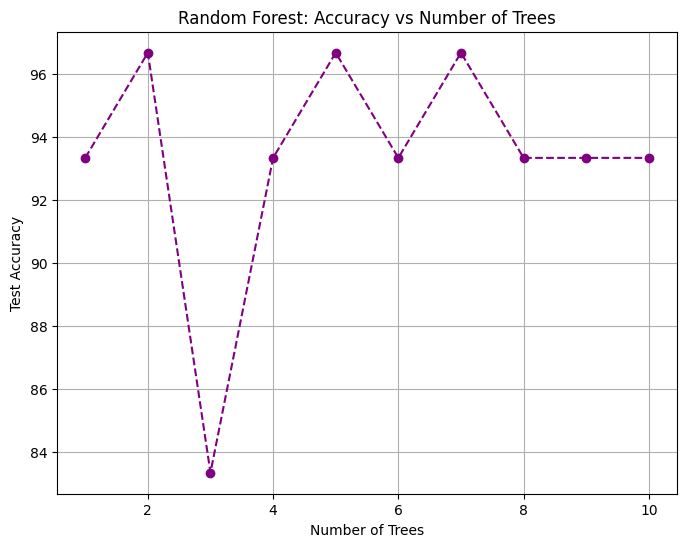

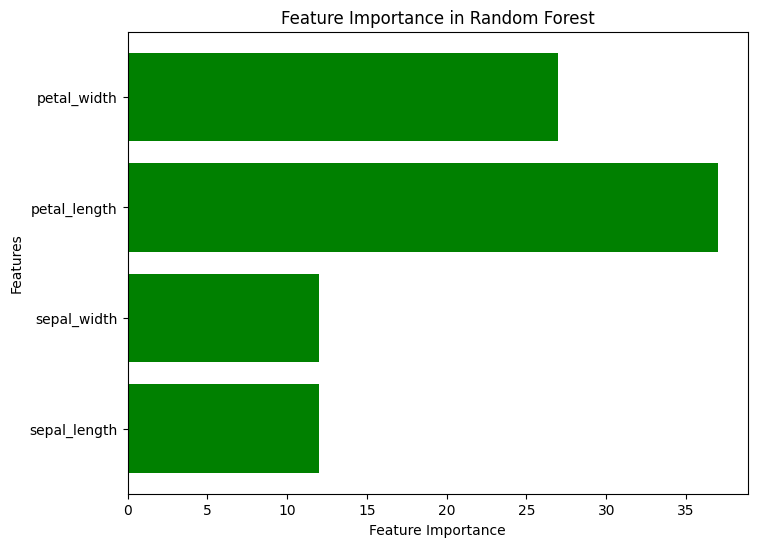

In [27]:
import matplotlib.pyplot as plt
import numpy as np

tree_range = list(range(1, 11))  
accuracies = [93.33,96.67,83.33,93.33,96.67,93.33,96.67,93.33,93.33,93.33] 

def plot_accuracy_vs_trees(tree_range, accuracies):
    plt.figure(figsize=(8, 6))
    plt.plot(tree_range, accuracies, marker='o', color='purple', linestyle='--')
    plt.xlabel('Number of Trees')
    plt.ylabel('Test Accuracy')
    plt.title('Random Forest: Accuracy vs Number of Trees')
    plt.grid(True)
    plt.show()


tree_range = list(range(1, 11))  
accuracies = [93.33,96.67,83.33,93.33,96.67,93.33,96.67,93.33,93.33,93.33] 

plot_accuracy_vs_trees(tree_range, accuracies)


def plot_feature_importance(feature_importance):
    plt.figure(figsize=(8, 6))
    plt.barh(list(feature_importance.keys()), list(feature_importance.values()), color='green')
    plt.xlabel('Feature Importance')
    plt.ylabel('Features')
    plt.title('Feature Importance in Random Forest')
    plt.show()

feature_importance = {
    'sepal_length': 12.0,
    'sepal_width': 12.0,
    'petal_length': 37.0,
    'petal_width': 27.0
}

plot_feature_importance(feature_importance)
